# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1-5geMOpZxSkjDS81TqVWhlacCBYPY_k1?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install -U torch==1.13.1+cu116 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
for line in open('SMSSpamCollection'):
  if line[0:3] == 'ham':
    print(line)
    break

for line in open('SMSSpamCollection'):
  if line[0:4] == 'spam':
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label value for a spam message is "spam", and the label value for a non-spam message is "ham".

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [4]:
spam_count = 0
ham_count = 0

for line in open('SMSSpamCollection'):
  if line[0:3] == 'ham':
    ham_count += 1
  elif line[0:4] == 'spam':
    spam_count += 1

print("There are " + str(ham_count) + " non-spam messages in the data set")
print("There are " + str(spam_count) + " spam messages in the data set")

There are 4827 non-spam messages in the data set
There are 747 spam messages in the data set


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:


*   Less complex since there are less characters than there are words
*   Can focus and recognize smaller details such as mistakes in spelling

Disadvantages:


*   Less attention to the context/meaning of the phrases (harder to catch semantic patterns)
*   Higher computational cost due to more parameters





### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [3]:
import torchtext

# specifying fields
text_field = torchtext.data.Field(tokenize=lambda x:x,
                                        include_lengths=True,
                                         batch_first = True)
label_field = torchtext.data.Field(sequential=False,
                                         use_vocab=False,
                                         is_target=True,
                                          batch_first = True,
                                          preprocessing=lambda x: int(x == 'spam')) # convert to binary (spam is 1, ham is 0)
fields = [('label', label_field), ('sms', text_field)]

dataset = torchtext.data.TabularDataset(path='SMSSpamCollection',
                                              format='tsv',
                                              fields=fields)

train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2]) # splitting dataset

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [4]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In this case, we have many more non-spam than spam messages which will result in our model performing better on non-spam messages. Thus, when we are testing the data, a higher accuracy could just be a result of there being more non-spam messages in the test dataset. Having a balanced training set is helpful for training our neural network because it will reduce the model's bias so that it can have a relatively similar performance (accuracy) for both classes.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [5]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x79bb775d1030>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, '4': 36, 'I': 37, 'N': 38, 'x': 39, 'A': 40, '7': 41, '3': 42, '6': 43, '!': 44, 'R': 45, ',': 46, '9': 47, 'P': 48, 'U': 49, 'W': 50, 'M': 51, 'H': 52, 'L': 53, 'D': 54, 'G': 55, 'B': 56, 'F': 57, 'Y': 58, "'": 59, '/': 60, '?': 61, '£': 62, '&': 63, 'X': 64, '-': 65, ':': 66, 'z': 67, 'j': 68, 'V': 69, 'K': 70, '*': 71, 'J': 72, ')': 73, '+': 74, ';': 75, 'q': 76, '(': 77, '"': 78, 'Q': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '|': 87, '\x92': 88, '$': 89, '‘': 90, '<': 91, '%': 92, '_': 93, '[': 94, ']': 95, '¡': 96, '…': 97, '’': 98, '“

text_field.vocab.stoi is a dictionary that maps the strings in the vocabulary to their corresponding numerical indices. <br>
text_field.vocab.itos is a list that maps the numerical indices to the corresponding string in the vocabulary.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

\<unk> means unknown and represents a token that is unknown in the vocabulary. <br>
\<pad> means padding and is inserted to ensure that the sequences are of uniform length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [6]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [25]:
i = 0
#pad_count = 0
for batch in train_iter:
  if i == 10:
    break
  max_length = batch.sms[1].max()
  print("The maximum length of the input sequence in batch " + str(i + 1) + " is " + str(int(max_length)) + ".")
  pad_count = (batch.sms[1].max() - batch.sms[1]).sum()
  print("The number of <pad> tokens in batch " + str(i + 1) + " is " + str(int(pad_count)))
  print("\n")
  i += 1

The maximum length of the input sequence in batch 1 is 159.
The number of <pad> tokens in batch 1 is 11


The maximum length of the input sequence in batch 2 is 39.
The number of <pad> tokens in batch 2 is 21


The maximum length of the input sequence in batch 3 is 74.
The number of <pad> tokens in batch 3 is 16


The maximum length of the input sequence in batch 4 is 107.
The number of <pad> tokens in batch 4 is 29


The maximum length of the input sequence in batch 5 is 40.
The number of <pad> tokens in batch 5 is 9


The maximum length of the input sequence in batch 6 is 147.
The number of <pad> tokens in batch 6 is 0


The maximum length of the input sequence in batch 7 is 166.
The number of <pad> tokens in batch 7 is 24


The maximum length of the input sequence in batch 8 is 41.
The number of <pad> tokens in batch 8 is 2


The maximum length of the input sequence in batch 9 is 156.
The number of <pad> tokens in batch 9 is 13


The maximum length of the input sequence in batch 10 

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [10]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [136]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.name = "RNN"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size) # initialize hidden state with zeros
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [7]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for batch in data:
        text = batch.sms
        labels = batch.label
        output = model(text[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [8]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name,
                                              learning_rate,
                                              epoch)
    return path

def get_loss(model, data, criterion):
  total_loss = 0.0
  i = 0
  for batch in data:
    text = batch.sms
    labels = batch.label
    output = model(text[0])
    loss = criterion(output, labels)
    total_loss += loss.item()
    i+= 1
  return float(total_loss)/ (i+1)

def train(model, train_loader, val_loader, num_epochs=1, lr=0.01):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  total_train_loss = 0.0
  i = 0

  for epoch in range(num_epochs):
    for batch in train_loader:
      text = batch.sms
      labels = batch.label
      optimizer.zero_grad()
      output = model(text[0])
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
      i+= 1

    train_acc[epoch] = get_accuracy(model, train_loader)
    train_loss[epoch] = float(total_train_loss)/ (i+1)
    val_acc[epoch] = get_accuracy(model, val_loader)
    val_loss[epoch] = get_loss(model, val_loader, criterion)

    print(("Epoch {}: Train acc: {}, Train loss: {} |"+
                  "Validation acc: {}, Validation loss: {}").format(
                      epoch + 1,
                      train_acc[epoch],
                      train_loss[epoch],
                      val_acc[epoch],
                      val_loss[epoch]))

# Save the current model (checkpoint) to a file
  model_path = get_model_name(model.name, lr, epoch)
  torch.save(model.state_dict(), model_path)
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

  plot_training_curve(model_path)


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [9]:
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
# 1
model = RNN(50)
train(model, train_iter, valid_iter, num_epochs=20, lr=0.1)
# The validation accuracy and loss were very noisy
# final training accuracy of 49%, validation accuracy of 59%

In [ ]:
# 2
# lowered the learning rate to reduce the noise
model = RNN(50)
train(model, train_iter, valid_iter, num_epochs=20, lr=0.01)
# final training accuracy of 79%, validation accuracy of 81%
# there was still quite a bit of noise, so we can try lowering the learning rate more
# the model seems to be performing poorly on the validation data, so we can try increasing the hidden units
# to see if the model will be able to capture more complex features

In [ ]:
# 3
# increased number of hidden units to 64, and decreased learning rate
model = RNN(64)
train(model, train_iter, valid_iter, num_epochs=20, lr=0.001)
# final training accuracy of 94%, validation accuracy of 94%
# there is still quite of bit of noise in the training and validation accuracies, so we can lower the learning rate a bit more
# the training loss seems to still be decreasing as well, so we can increase the number of epochs to see if it will start to converge

In [ ]:
# 4
# decreased learning rate and increased number of epochs
model = RNN(64)
train(model, train_iter, valid_iter, num_epochs=30, lr=0.0001)
# final training accuracy of 96%, validation accuracy of 95%
# the amount of noise reduced significantly for the training and validation accuracies and losses
# we can try altering the way we pool the rnn and see if that improves our model

In [10]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.name = "RNN"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size) # initialize hidden state with zeros
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
# 5
# changed the pooling method
model = RNN(64)
train(model, train_iter, valid_iter, num_epochs=30, lr=0.0001)
# final training accuracy of 97%, validation accuracy of 98%
# the accuracies increased and the losses decreased from the previous model, so changing the pooling method worked
# the losses are still decreasing, so we can try to increase the number of epochs again

In [ ]:
# increased number of epochs
model_6 = RNN(64)
train(model, train_iter, valid_iter, num_epochs=40, lr=0.0001)
# it seems like our model is overfitting to the train set and is less effective at generalizing to the validation set
# final training accuracy of 99%, validation accuracy of 98%

Epoch 1: Train acc: 0.5441248972884142, Train loss: 0.6849419198309382 |Validation acc: 0.18116591928251122, Validation loss: 0.6838741915093528
Epoch 2: Train acc: 0.6179129005751849, Train loss: 0.6733171890049628 |Validation acc: 0.3219730941704036, Validation loss: 0.6720523917012744
Epoch 3: Train acc: 0.8228430566967954, Train loss: 0.6239979837725802 |Validation acc: 0.695067264573991, Validation loss: 0.6207649095190896
Epoch 4: Train acc: 0.9160230073952342, Train loss: 0.5713053055351076 |Validation acc: 0.9246636771300448, Validation loss: 0.3401523257295291
Epoch 5: Train acc: 0.9257189811010682, Train loss: 0.5148898911463665 |Validation acc: 0.9336322869955157, Validation loss: 0.2588689389328162
Epoch 6: Train acc: 0.9513557929334429, Train loss: 0.46954306148791586 |Validation acc: 0.9327354260089686, Validation loss: 0.2899940703064203
Epoch 7: Train acc: 0.9554642563681183, Train loss: 0.4325360734884381 |Validation acc: 0.9488789237668162, Validation loss: 0.21186437

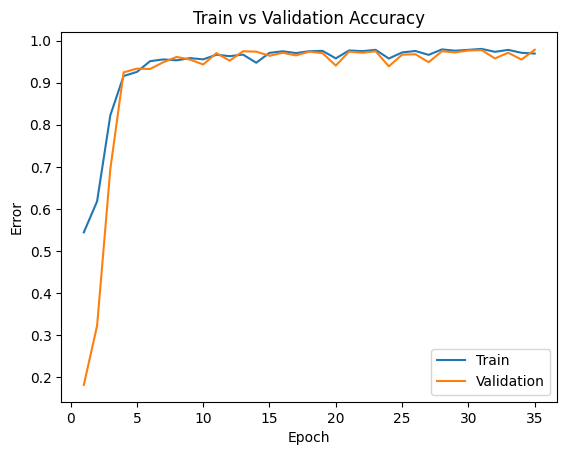

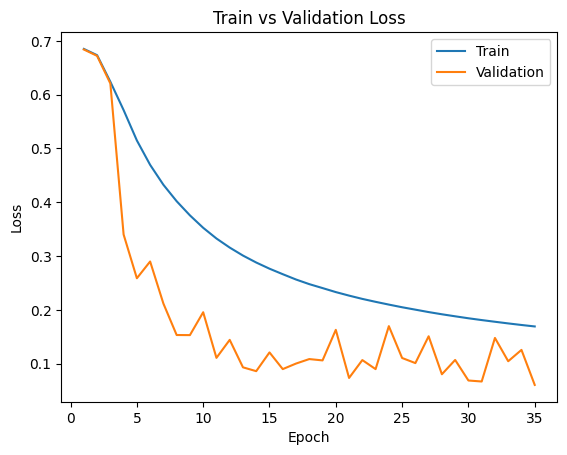

In [150]:
# lowered the number of epochs
model_7 = RNN(64)
train(model_7, train_iter, valid_iter, num_epochs=35, lr=0.0001)
# final training accuracy of 97%, validation accuracy of 98%
# choose this as the final model

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [14]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
valid_nonspam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_negatives = 1 - get_accuracy(model_7, valid_spam_iter)
false_positives = 1 - get_accuracy(model_7, valid_nonspam_iter)

print("False positive rate: ", false_positives)
print("False negative rate: ", false_negatives)

False positive rate:  0.029227557411273475
False negative rate:  0.031847133757961776


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

With false negatives, the spam messages would show as non-spam to the user, which would just take up space in the user's message inbox. <br>
With false positives, the non-spam messages would show as spam message, which could cause the user's to miss potentially important information.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [15]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_acc = get_accuracy(model_7, test_iter)
print("Test accuracy: ", test_acc)

Test accuracy:  0.9631956912028725


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [18]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
test_nonspam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_negatives = 1 - get_accuracy(model_7, test_spam_iter)
false_positives = 1 - get_accuracy(model_7, test_nonspam_iter)

print("False positive rate: ", false_positives)
print("False negative rate: ", false_negatives)

False positive rate:  0.031600407747196746
False negative rate:  0.052631578947368474


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [24]:
msg = "machine learning is sooo cool!"
indices = []
for char in msg:
  indices.append(text_field.vocab.stoi[char])

indices = torch.tensor(indices)
indices = indices.unsqueeze(0)
output = model_7(indices)
prob = torch.nn.functional.softmax(output, dim=1)
print("The probability that the SMS message is spam is " + str(float(prob[0][1] * 100)) + "%.")


The probability that the SMS message is spam is 4.7585906982421875%.


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam should be a relatively simple task, however, there will be occasional errors because some spam messages may be extremely similar to real messages. <br>
A simple baseline model that we could build is to make a list of commonly used punctuation, words, maybe links (spam messages could have links attached that cause user's to download viruses onto their devices) from the training set. The list could then be used to classify other messages as spam if there are a certain amount of elements from that list used in the message.  